In [27]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score, r2_score
from wearsed.training.metric_info import get_ahis, combine_fold_results

In [28]:
def get_ahi_severity_class(ahi):
    if ahi < 5:   # Normal
        return 0
    if ahi < 15:  # Mild
        return 1
    if ahi < 30:  # Moderate
        return 2
    return 3      # Severe

def get_ahi_severity_class_NBL(ahi):
    if ahi < 5 and ahi >= 2.4:
        return 1  # Mild
    if ahi > 5 and ahi < 7:
        return 0  # Normal
    if ahi < 15 and ahi >= 12.4:
        return 2  # Moderate
    if ahi > 15 and ahi < 17.4:
        return 1  # Mild
    if ahi < 30 and ahi >= 26.6:
        return 3  # Severe
    if ahi > 30 and ahi < 35.2:
        return 2  # Moderate
    return -1     # No NBL

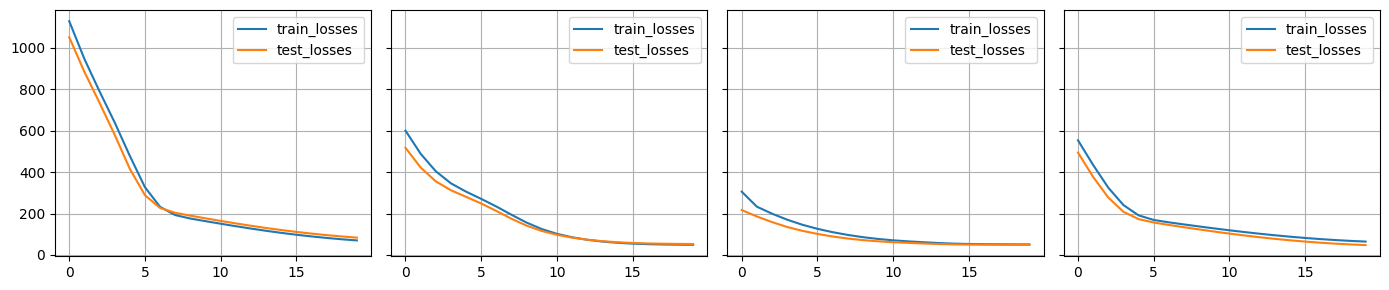

In [13]:
_, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True, sharey=True)
for fold in range(4):
        pd.read_csv(f'../wearsed/training/ahi_correction/output/corr/f-{fold}/losses.csv').plot(ax=axs[fold])
        axs[fold].grid()
plt.tight_layout()

In [26]:
ahis_pred, ahis_true = [], []
for fold in range(4):
    df = pd.read_csv(f'../wearsed/training/ahi_correction/output/corr/f-{fold}/epoch_19_predictions.csv')
    ahis_pred += [float(n) for n in df['ahi_predictions'].values]
    ahis_true += [float(n) for n in df['ahi_targets'].values]
len(ahis_pred), len(ahis_true)

(1792, 1792)

In [29]:
print('### Calculating Severity classes with and without NBL')
ahi_severitys_pred = [get_ahi_severity_class(ahi) for ahi in ahis_pred]
ahi_severitys_true = [get_ahi_severity_class(ahi) for ahi in ahis_true]
ahi_severitys_pred_NBL = []
for ahi, ahi_severity_true in zip(ahis_pred, ahi_severitys_true):
    hard_severity = get_ahi_severity_class(ahi)
    soft_severity = get_ahi_severity_class_NBL(ahi)
    if soft_severity == ahi_severity_true:
        ahi_severitys_pred_NBL.append(soft_severity)
    else:
        ahi_severitys_pred_NBL.append(hard_severity)

print('### Generate the confusion matrix')
confusion_matrix = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred, ahi_severitys_true):
    confusion_matrix[ahi_severity_true][ahi_severity_pred] += 1
confusion_matrix_NBL = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred_NBL, ahi_severitys_true):
    confusion_matrix_NBL[ahi_severity_true][ahi_severity_pred] += 1

### Calculating Severity classes with and without NBL
### Generate the confusion matrix


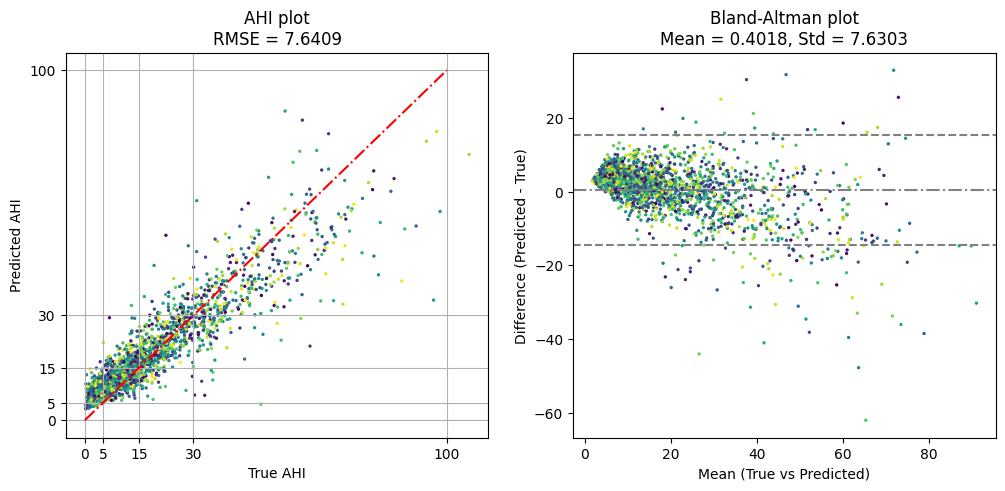

In [30]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=2, c=np.random.rand(len(ahis_true), 1))
ax1.plot([0, 100], [0, 100], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 100])
ax1.set_yticks([0, 5, 15, 30, 100])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=2, c=np.random.rand(len(ahis_true), 1))
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

In [31]:
r2_score(ahis_pred, ahis_true)

0.6974865241069732

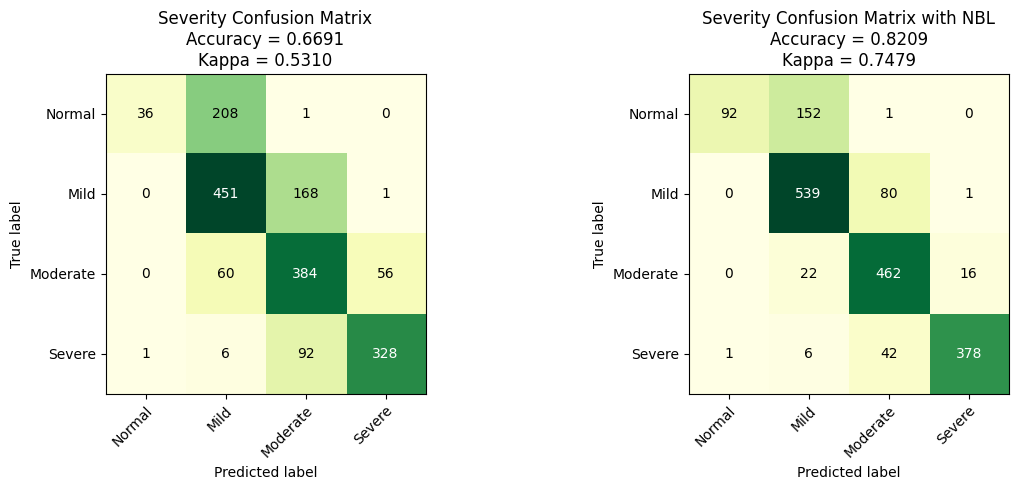

In [32]:
# Create Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
true_labels = pred_labels = ['Normal', 'Mild', 'Moderate', 'Severe']

# Show Data
ax1.imshow(confusion_matrix, cmap='YlGn')
ax2.imshow(confusion_matrix_NBL, cmap='YlGn')

for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax1.text(j, i, confusion_matrix[i][j], ha='center', va='center', color='w' if confusion_matrix[i][j] > 300 else 'k')
for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax2.text(j, i, confusion_matrix_NBL[i][j], ha='center', va='center', color='w' if confusion_matrix_NBL[i][j] > 300 else 'k')

# Labels
for ax in [ax1, ax2]:
    ax.set_xticks(range(len(true_labels)), labels=true_labels, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(pred_labels)), labels=pred_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
ax1.set_title(f'Severity Confusion Matrix\nAccuracy = {np.trace(confusion_matrix)/np.sum(confusion_matrix):.4f}\nKappa = {cohen_kappa_score(ahi_severitys_pred, ahi_severitys_true):.4f}')
ax2.set_title(f'Severity Confusion Matrix with NBL\nAccuracy = {np.trace(confusion_matrix_NBL)/np.sum(confusion_matrix_NBL):.4f}\nKappa = {cohen_kappa_score(ahi_severitys_pred_NBL, ahi_severitys_true):.4f}')

plt.tight_layout()
plt.show()